In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings


# Игнорировать все предупреждения
warnings.filterwarnings('ignore')


def generate_time_series_features(df, target_variable, max_lag=0, rolling_window_size=0, expanding_window_size=0, include_diffs=False):
    df_features = df[[target_variable]].copy()

    # Создание лагов
    if max_lag > 0:
        for lag in range(1, max_lag + 1):
            df_features.insert(0, f"{target_variable}_lag_{lag}", df[target_variable].shift(lag))

    # Создание скользящих окон только для среднего, начиная с окна размером 2
    if rolling_window_size > 1:
        for window_size in range(2, rolling_window_size + 1):
            df_features[f"{target_variable}_rolling_mean_{window_size}"] = df[target_variable].rolling(window=window_size).mean()

    # Создание раскрывающихся окон
    if expanding_window_size > 0:
        for window_size in range(1, expanding_window_size + 1):
            df_features[f"{target_variable}_cum_mean_{window_size}"] = df[target_variable].expanding(min_periods=window_size).mean()

    # Создание разностей
    if include_diffs:
        df_features[f"{target_variable}_diff"] = df[target_variable].diff()

    # Удаление строк с NaN значениями
    df_features.dropna(inplace=True)

    return df_features

# def generate_time_series_features(df, target_variable, max_lag=0, rolling_window_size=0, expanding_window_size=0, include_diffs=False):
#     df_features = df.copy()

#     # Создание лагов для всех переменных
#     if max_lag > 0:
#         for lag in range(1, max_lag + 1):
#             for col in df.columns:
#                 df_features.insert(0, f"{col}_lag_{lag}", df[col].shift(lag))

#     # Создание скользящих окон только для среднего, начиная с окна размером 2
#     if rolling_window_size > 1:
#         for window_size in range(2, rolling_window_size + 1):
#             for col in df.columns:
#                 df_features[f"{col}_rolling_mean_{window_size}"] = df[col].rolling(window=window_size).mean()

#     # Создание раскрывающихся окон
#     if expanding_window_size > 0:
#         for window_size in range(1, expanding_window_size + 1):
#             for col in df.columns:
#                 df_features[f"{col}_cum_mean_{window_size}"] = df[col].expanding(min_periods=window_size).mean()

#     # Создание разностей для всех переменных
#     if include_diffs:
#         for col in df.columns:
#             df_features.insert(0, f"{col}_diff", df[col].diff())

#     # Удаление строк с NaN значениями
#     df_features.dropna(inplace=True)

#     return df_features

def prepare_ml_data(df, target_variable, max_lag=0, rolling_window_size=0, expanding_window_size=0, include_diffs=False, forecast_horizon=12):
    df_features = generate_time_series_features(
        df, target_variable, max_lag=max_lag, rolling_window_size=rolling_window_size, 
        expanding_window_size=expanding_window_size, include_diffs=include_diffs
    )

    # Создание y, содержащего только будущие значения
    y = np.array([df_features[target_variable].shift(-i).values for i in range(1, forecast_horizon + 1)]).T

    print(df_features.shape)
    print(y.shape)

    # Удаление строк, содержащих NaN
    valid_idx = ~np.isnan(y).any(axis=1)
    y = y[valid_idx]

    # Приведение X к соответствующей длине y и удаление NaN
    X = df_features.iloc[valid_idx]

    return X, y

# def prepare_ml_data(df, target_variable, max_lag=0, rolling_window_size=0, expanding_window_size=0, include_diffs=False, forecast_horizon=12):
#     df_features = generate_time_series_features(
#         df, target_variable, max_lag=max_lag, rolling_window_size=rolling_window_size, 
#         expanding_window_size=expanding_window_size, include_diffs=include_diffs
#     )

#     # Создание y, содержащего только будущие значения целевой переменной (сила ветра)
#     y = np.array([df_features[target_variable].shift(-i).values for i in range(1, forecast_horizon + 1)]).T

#     # Удаление строк, содержащих NaN
#     valid_idx = ~np.isnan(y).any(axis=1)
#     y = y[valid_idx]

#     # Приведение X к соответствующей длине y и удаление NaN
#     X = df_features.iloc[valid_idx]

#     return X, y

# Объединенная функция для вычисления метрик
def calculate_metrics(y_true, y_pred, y_train):
    metrics = {}

    # MASE
    naive_forecast = np.roll(y_train, 1)[1:]
    mae_naive = np.mean(np.abs(y_train[1:] - naive_forecast))
    metrics["MASE"] = np.mean(np.abs(y_true - y_pred)) / mae_naive

    # sMAPE
    metrics["sMAPE"] = 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

    # RMSE
    metrics["RMSE"] = np.sqrt(mean_squared_error(y_true, y_pred))

    # MAE
    metrics["MAE"] = mean_absolute_error(y_true, y_pred)

    # R²
    metrics["R²"] = r2_score(y_true, y_pred)

    # MSE
    metrics["MSE"] = mean_squared_error(y_true, y_pred)

    # MAPE
    metrics["MAPE"] = 100 * np.mean(np.abs((y_true - y_pred) / y_true))

    return metrics

def check_time_delta(df):
    """
    Функция для вычисления дельты времени между наблюдениями в индексированном по времени DataFrame.
    Выдает ошибку, если дельты различаются.

    :param df: DataFrame с индексом времени
    :return: Дельта времени (в виде pd.Timedelta), если все дельты одинаковые
    """
    # Вычисляем разницу между соседними значениями индекса
    time_deltas = df.index.to_series().diff().dropna().unique()

    if len(time_deltas) == 1:
        return time_deltas[0]
    else:
        raise ValueError("Обнаружены разные значения дельты времени между наблюдениями.")


# Загрузка данных
file_path = "Meteo1-2023-15min(resampled).csv"
df = pd.read_csv(file_path, delimiter=",")

# Преобразование времени в datetime и установка индекса
df["time_YYMMDD_HHMMSS"] = pd.to_datetime(
    df["time_YYMMDD_HHMMSS"], format="%Y-%m-%d %H:%M:%S"
)
df.set_index("time_YYMMDD_HHMMSS", inplace=True)
df.head()

,WindSpeedMax,WindDirection,AirTemperature,AirPressure,AirHumidity,WindSpeed
time_YYMMDD_HHMMSS,,,,,,
2023-01-01 00:00:00,5.433333,292.256367,4.926154,1028.344333,88.889567,4.422906
2023-01-01 00:15:00,6.100000,293.810423,4.976190,1028.433600,88.600962,4.739206
2023-01-01 00:30:00,5.200000,303.513670,4.957143,1028.502367,88.833338,4.109524
2023-01-01 00:45:00,5.700000,297.176083,4.835715,1028.429633,90.213968,4.430159
2023-01-01 01:00:00,6.000000,295.580110,4.493651,1028.400100,89.865232,4.828571


In [8]:
# Настройка параметров
forecast_horizon_time = pd.Timedelta(hours=3)
max_lag = 360  # Максимальное количество лагов
rolling_window_size = 360  # Максимальный размер окна для скользящих агрегатов
expanding_window_size = 360  # Максимальный размер окна для раскрывающихся агрегатов
include_diffs = True  # Включить разности
target_value = "AirTemperature"

In [9]:
from sklearn.model_selection import train_test_split
delta = check_time_delta(df)
forecast_horizon = int(forecast_horizon_time / delta)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

# Подготовка данных для машинного обучения
X_train, y_train = prepare_ml_data(
    df_train, 
    target_value, 
    max_lag=max_lag, 
    rolling_window_size=rolling_window_size, 
    expanding_window_size=expanding_window_size, 
    include_diffs=include_diffs,
    forecast_horizon=forecast_horizon
)

# Подготовка данных для машинного обучения
X_test, y_test = prepare_ml_data(
    df_test, 
    target_value, 
    max_lag=max_lag, 
    rolling_window_size=rolling_window_size, 
    expanding_window_size=expanding_window_size, 
    include_diffs=include_diffs,
    forecast_horizon=forecast_horizon
)

# Проверка размерностей
print("Размерность X_train:", X_train.shape)
print("Размерность y_train:", y_train.shape)
# Проверка размерностей
print("Размерность X_test:", X_test.shape)
print("Размерность y_test:", y_test.shape)

(27672, 1081)
(27672, 12)
(6649, 1081)
(6649, 12)
Размерность X_train: (27660, 1081)
Размерность y_train: (27660, 12)
Размерность X_test: (6637, 1081)
Размерность y_test: (6637, 12)


In [13]:
import plotly.graph_objs as go
import plotly.subplots as sp

def plot_first_samples(X, y, df_, target_variable, num_samples, max_lag, forecast_horizon, y_pred_values=None):
    """
    Функция для визуализации первых фрагментов данных X и y с использованием Plotly.
    
    :param X: Матрица признаков (ветер и его лаги)
    :param y: Целевая переменная (ветер на 12 шагов вперед)
    :param df: Исходный DataFrame с данными
    :param target_variable: Целевая переменная (например, "WindSpeed")
    :param num_samples: Количество первых выборок для визуализации
    """
    # Создание субплотов
    fig = sp.make_subplots(rows=num_samples, cols=1, shared_xaxes=False, vertical_spacing=0.01)
    
    for i in range(0, num_samples):
        idx = np.random.randint(0, len(X))  # Используем фиксированные индексы начиная с 0
        
        # Фильтрация лагов только для целевой переменной и сортировка по убыванию, чтобы lag_1 был последним
        lag_features = [col for col in X.columns if f"{target_variable}_lag" in col]
        x_lags = X[lag_features + [target_variable]].iloc[idx].values  # Добавляем текущее значение перед лагами
        
        if df_ is not None:
            # Получение будущих значений из X
            start_time = X.iloc[idx].name - pd.Timedelta(minutes=max_lag * 15)
            end_time = X.iloc[idx].name + pd.Timedelta(minutes=15*forecast_horizon)
            future_x_values = df_[target_variable].loc[start_time:end_time].values

        # Получение значений y (прогноз на 12 шагов вперед)
        y_values = y[idx]

        # Добавление данных на график
        show_legend = i == 0  # Показывать легенду только на первом графике

        fig.add_trace(go.Scatter(x=list(range(len(x_lags))), y=x_lags,
                                 mode='lines+markers', name='X (WindSpeed and lags)',
                                 line=dict(color='green'), showlegend=show_legend), row=i+1, col=1)
        
        fig.add_trace(go.Scatter(x=list(range(len(x_lags), len(x_lags) + len(y_values))), y=y_values,
                                 mode='lines+markers', name='y (Future WindSpeed)',
                                 line=dict(color='red'), showlegend=show_legend), row=i+1, col=1)
        
        if df_ is not None:
            fig.add_trace(go.Scatter(x=list(range(0, len(future_x_values))), y=future_x_values,
                                 mode='lines', name='X (Future from Observations)',
                                 line=dict(color='blue', dash='dash'), showlegend=show_legend), row=i+1, col=1)
        
        if y_pred_values is not None:
            fig.add_trace(go.Scatter(x=list(range(len(x_lags), len(x_lags) + len(y_pred_values[i]))), y=y_pred_values[i],
                                     mode='lines+markers', name='y_pred (Predicted WindSpeed)',
                                     line=dict(color='blue'), showlegend=show_legend), row=i+1, col=1)
        
        fig.add_vline(x=len(x_lags)-1, line=dict(color='gray', dash='dash'), row=i+1, col=1)
    
    # Обновление разметки и отображение графика
    fig.update_layout(height=num_samples * 400, width=1500, title_text="First Samples Visualization")
    fig.show()

# Визуализация первых выборок с учетом будущих значений
plot_first_samples(X_train, y_train, df, target_value, num_samples=10, max_lag=max_lag, forecast_horizon=forecast_horizon)


Using device: cuda
Epoch 1/1000, Train Loss: 0.21136880942851033, Val Loss: 0.05174415186047554, Train R²: -0.729353666305542, Val R²: 0.9109498858451843
Epoch 2/1000, Train Loss: 0.04947711770004089, Val Loss: 0.04783104732632637, Train R²: -0.9307259917259216, Val R²: 0.917682945728302
Epoch 3/1000, Train Loss: 0.042202763327764806, Val Loss: 0.034028101712465286, Train R²: -0.9521908760070801, Val R²: 0.941434919834137
Epoch 4/1000, Train Loss: 0.04023179053029883, Val Loss: 0.03717133775353432, Train R²: -0.9618139863014221, Val R²: 0.9360253810882568
Epoch 5/1000, Train Loss: 0.03821052016194807, Val Loss: 0.03240742161870003, Train R²: -0.97076815366745, Val R²: 0.9442229270935059
Epoch 6/1000, Train Loss: 0.036731551888339015, Val Loss: 0.04423302039504051, Train R²: -0.9410009980201721, Val R²: 0.9238759875297546
Epoch 7/1000, Train Loss: 0.03458702936768532, Val Loss: 0.03266610950231552, Train R²: -0.982684850692749, Val R²: 0.9437776207923889
Epoch 8/1000, Train Loss: 0.0352

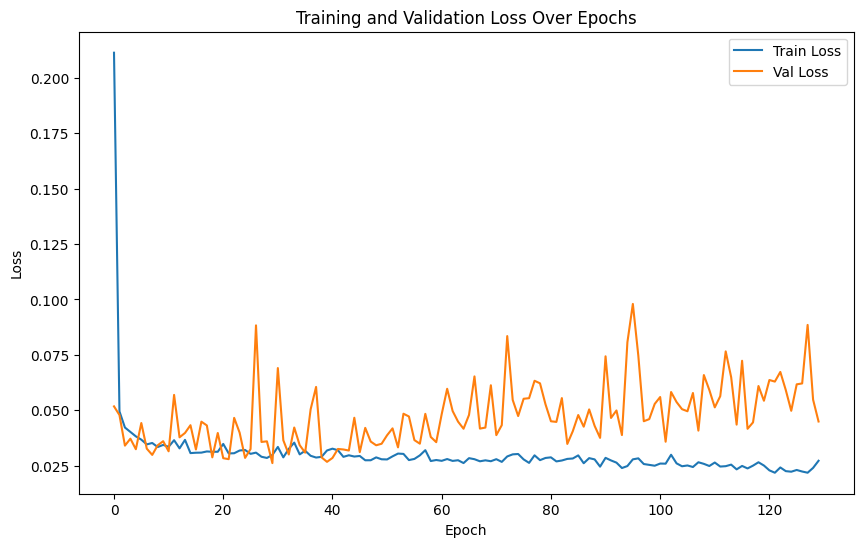

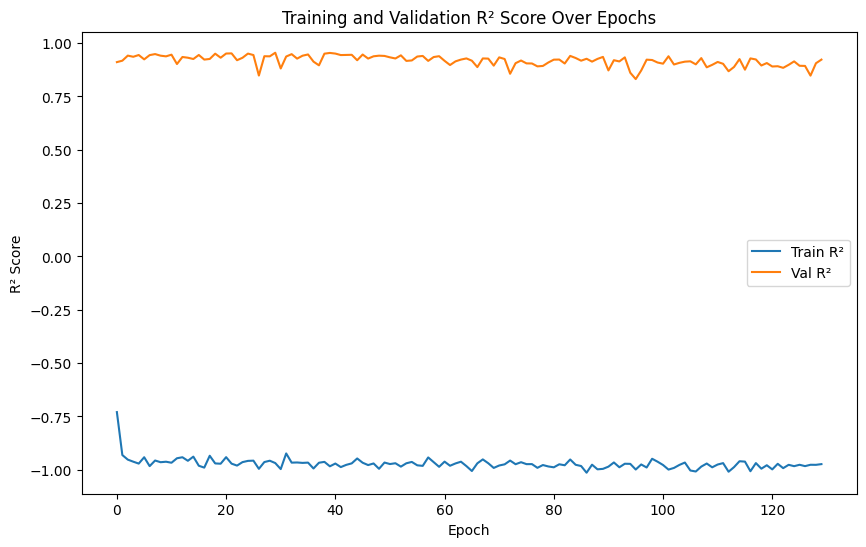

Test Loss: 0.04492074251174927, Test R²: 0.9226900935173035
MASE: 4.923944696440472
sMAPE: 18.806225138162365
RMSE: 1.6459596717569758
MAE: 1.2625164925778474
R²: 0.9226901384016005
MSE: 2.709183241050331
MAPE: 33.6568916682232


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

# Проверка наличия GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Разделение данных на обучающую и тестовую выборки
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация данных
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

# Определение модели
# class ForecastingModel(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(ForecastingModel, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, output_dim)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.relu(self.fc2(x))
#         x = self.fc3(x)  # Линейный выход для задачи регрессии
#         return x

# Определение модели
class ForecastingModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ForecastingModel, self).__init__()
        
        # Первый блок слоев
        self.fc1 = nn.Linear(input_dim, 1024)  # Увеличение размерности первого слоя
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)  # Увеличение размерности второго слоя
        self.bn2 = nn.BatchNorm1d(512)
        
        # Второй блок слоев
        self.fc3 = nn.Linear(512, 256)  # Увеличение размерности третьего слоя
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)  # Увеличение размерности четвертого слоя
        self.bn4 = nn.BatchNorm1d(128)
        
        # Третий блок слоев
        self.fc5 = nn.Linear(128, 64)  # Увеличение размерности пятого слоя
        self.bn5 = nn.BatchNorm1d(64)
        self.fc6 = nn.Linear(64, output_dim)
        
        # Функции активации и регуляризация
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Пропуск через первый блок слоев
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        # Пропуск через второй блок слоев
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        
        # Пропуск через третий блок слоев
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)  # Линейный выход для задачи регрессии
        
        return x

# Параметры модели
input_dim = X_train_tensor.shape[1]
output_dim = y_train_tensor.shape[1]
model = ForecastingModel(input_dim, output_dim).to(device)

# Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Настройка OneCycleLR
epochs = 1000
batch_size = 256
steps_per_epoch = (len(X_train_tensor) + batch_size - 1) // batch_size  # Округление вверх для целого числа шагов
total_steps = steps_per_epoch * epochs  # Общие шаги для обучения
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=total_steps)

# Параметры ранней остановки
early_stopping_patience = 100
early_stopping_counter = 0

# Переменные для хранения метрик
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

# Переменная для отслеживания лучшей модели
best_val_loss = float('inf')
best_model_state = None

# Обучение модели
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size()[0])
    
    epoch_train_loss = 0
    y_train_pred = []
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Собираем предсказания для расчета R²
        y_train_pred.extend(outputs.cpu().detach().numpy())
        
        # Шаг планировщика
        scheduler.step()

        epoch_train_loss += loss.item()

    # Преобразуем предсказания в массив
    y_train_pred = np.array(y_train_pred)

    # Валидация модели
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_r2 = r2_score(y_val_tensor.cpu().numpy(), val_outputs.cpu().numpy())

    # Расчет R² для обучающей выборки
    train_r2 = r2_score(y_train_tensor.cpu().numpy(), y_train_pred)

    train_losses.append(epoch_train_loss / steps_per_epoch)
    val_losses.append(val_loss.item())
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

    # Сохранение лучшей модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        early_stopping_counter = 0  # Сброс счетчика ранней остановки
    else:
        early_stopping_counter += 1

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss/steps_per_epoch}, Val Loss: {val_loss.item()}, Train R²: {train_r2}, Val R²: {val_r2}')

    # Проверка на раннюю остановку
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Загрузка лучшей модели
model.load_state_dict(best_model_state)

# Графики потерь и R² на обучении и валидации
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_r2_scores, label='Train R²')
plt.plot(val_r2_scores, label='Val R²')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()
plt.title('Training and Validation R² Score Over Epochs')
plt.show()

# Оценка модели
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_val_tensor)
    test_loss = criterion(y_pred_tensor, y_val_tensor)
    test_r2 = r2_score(y_val_tensor.cpu().numpy(), y_pred_tensor.cpu().numpy())
    print(f'Test Loss: {test_loss.item()}, Test R²: {test_r2}')

# Преобразование прогнозов обратно к исходной шкале
y_pred_scaled = y_pred_tensor.cpu().numpy()
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Теперь y_pred содержит прогнозы на несколько шагов вперед
# Оценка модели на основе всех шагов прогноза
metrics = calculate_metrics(y_test, y_pred, y_train)

# Вывод метрик
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")


In [12]:
plot_first_samples(X_test, y_test, None, target_value, 10, max_lag, forecast_horizon, y_pred)